In [1]:
#加载全部数据到内存中
def get_data():
    from datasets import load_dataset
    import numpy as np

    #加载
    dataset = load_dataset('lansinuote/gen.1.celeba', split='train')

    #采样
    dataset = dataset.shuffle(0).select(range(2000))

    #图片转数据
    def f(data):
        images = data['image']

        data = []
        for i in images:
            i = i.resize((64, 64))
            i = np.array(i)
            i = (i - 127.5) / 127.5
            i = i.transpose(2, 0, 1)
            data.append(i)
        return {'image': data}

    dataset = dataset.map(function=f,
                          batched=True,
                          batch_size=1000,
                          num_proc=4,
                          remove_columns=list(dataset.features)[1:])

    #加载为numpy数据
    data = np.empty((2000, 3, 64, 64), dtype=np.float32)
    for i in range(len(dataset)):
        data[i] = dataset[i]['image']

    return data


data = get_data()

data.shape, data.min(), data.max()

Using custom data configuration lansinuote--gen.1.celeba-cdea5a503bf57939
Found cached dataset parquet (/root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-5eb78bab229fe5c7.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-03f004c5291f580c.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-e4d1bc770bb4c72e.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-f3c2638206a5e78a.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/lansinuote___parquet/lansinuote--gen.1.celeba-cdea5a503bf57939/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-819c8d4ea96c983d.arrow


((2000, 3, 64, 64), -1.0, 1.0)

In [2]:
import torch

loader = torch.utils.data.DataLoader(
    dataset=data,
    batch_size=64,
    shuffle=True,
    drop_last=True,
)

len(loader), next(iter(loader)).shape

(31, torch.Size([64, 3, 64, 64]))

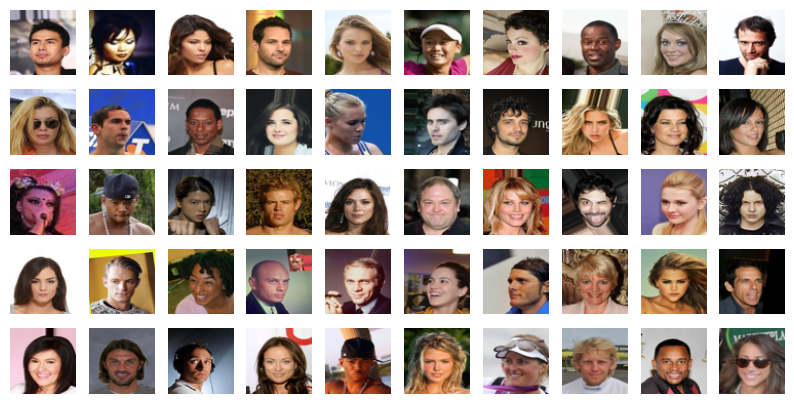

In [3]:
def show(images):
    from matplotlib import pyplot as plt

    if type(images) == torch.Tensor:
        images = images.to('cpu').detach().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]
        image = image.transpose(1, 2, 0)
        image = (image + 1) / 2

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(loader)))

In [4]:
cls = torch.nn.Sequential(
    torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=0),
    torch.nn.LeakyReLU(0.2),
    torch.nn.Flatten(),
    torch.nn.Linear(128, 1),
)

cls(torch.randn(2, 3, 64, 64)).shape

torch.Size([2, 1])

In [5]:
def block(in_channels,
          out_channels,
          kernel_size=5,
          stride=2,
          padding=1,
          dropout=True):

    sequential = [
        torch.nn.Conv2d(in_channels=in_channels,
                        out_channels=in_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1),
        torch.nn.LeakyReLU(),
        torch.nn.ConvTranspose2d(in_channels=in_channels,
                                 out_channels=out_channels,
                                 kernel_size=kernel_size,
                                 stride=stride,
                                 padding=padding),
        torch.nn.BatchNorm2d(num_features=out_channels),
        torch.nn.LeakyReLU(),
    ]

    if dropout:
        sequential.append(torch.nn.Dropout(p=0.2))

    return torch.nn.Sequential(*sequential)


gen = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=512 * 4 * 4),
    torch.nn.BatchNorm1d(num_features=512 * 4 * 4),
    torch.nn.Unflatten(dim=1, unflattened_size=(512, 4, 4)),
    block(512, 256),
    block(256, 128),
    block(128, 64),
    block(64, 3, dropout=False),
    torch.nn.UpsamplingNearest2d(size=64),
    torch.nn.Conv2d(in_channels=3,
                    out_channels=3,
                    kernel_size=1,
                    stride=1,
                    padding=0),
    torch.nn.Tanh(),
)

gen(torch.randn(2, 784)).shape

torch.Size([2, 3, 64, 64])

In [6]:
def set_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad_(requires_grad)


#修改loss函数
def wasserstein(pred, label):
    return -(pred * label).mean()


#裁剪参数
def clip_params():
    with torch.no_grad():
        for param in cls.parameters():
            param.clamp_(-0.02, 0.02)


#修改优化器类型
optimizer_cls = torch.optim.RMSprop(cls.parameters(), lr=2e-4)
optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr=2e-4)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

cls.to(device)
gen.to(device)

cls.train()
gen.train()

device

'cuda'

In [7]:
def train_cls():

    def update(data, label):
        pred = cls(data)
        label = torch.full((64, 1), label, device=device).float()
        loss = wasserstein(pred, label)

        loss.backward()
        optimizer_cls.step()
        optimizer_cls.zero_grad()

        return loss.item()

    set_requires_grad(cls, True)
    set_requires_grad(gen, False)
    
    #裁剪参数
    clip_params()

    with torch.no_grad():
        data = gen(torch.randn(64, 784, device=device))

    #负类的标签从0改成-1
    loss_sum = update(data, -1)

    data = next(iter(loader)).to(device)
    loss_sum += update(data, 1)

    return loss_sum


train_cls()

0.11942124925553799

In [8]:
def train_gen():
    set_requires_grad(cls, False)
    set_requires_grad(gen, True)

    pred = cls(gen(torch.randn(64, 784, device=device)))

    loss = wasserstein(pred, torch.ones(64, 1, device=device))
    loss.backward()
    optimizer_gen.step()
    optimizer_gen.zero_grad()

    return loss.item()


train_gen()

-0.351653128862381

0 -7.529120489954948 1.8256525993347168


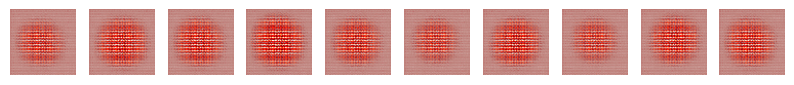

25000 -0.008744888007640839 -0.022089382633566856


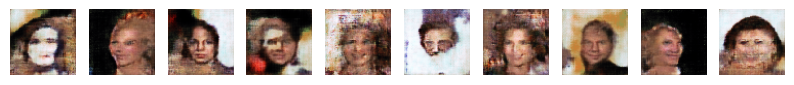

50000 -0.02151677990332246 0.02218259871006012


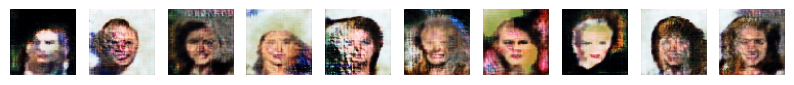

75000 -0.04299824684858322 -0.08012528717517853


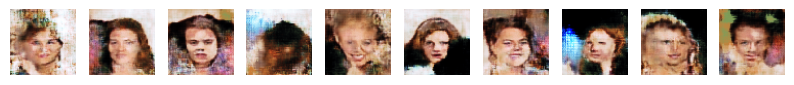

100000 -0.0329664908349514 -0.016476735472679138


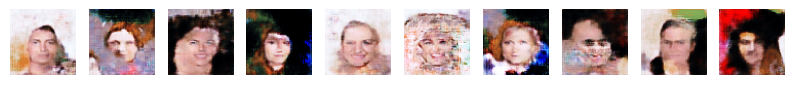

125000 -0.018838961608707905 -0.001811180729418993


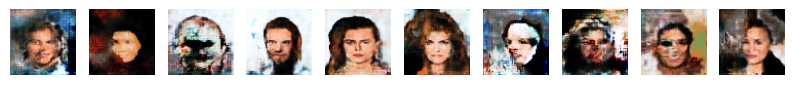

150000 -0.025308921933174133 -0.007785217836499214


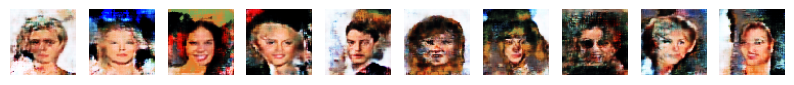

175000 -0.06356492638587952 -0.04528452455997467


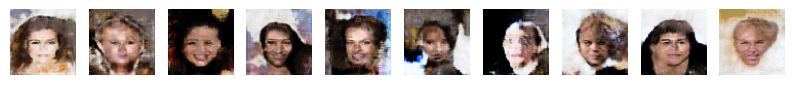

200000 -0.01344749704003334 0.05327881500124931


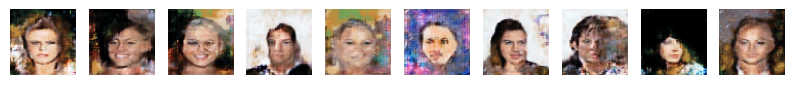

225000 -0.017636984586715698 -0.0365908108651638


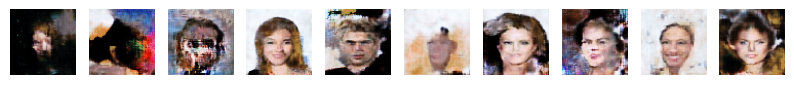

250000 -0.11584257148206234 -0.009485947899520397


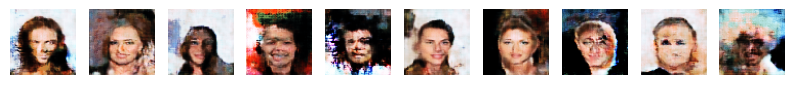

275000 -0.13147703977301717 -0.0109476987272501


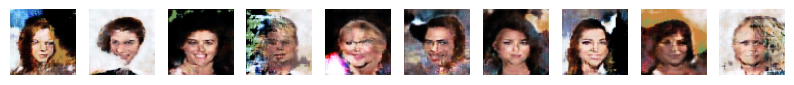

300000 0.2201131284236908 0.23190857470035553


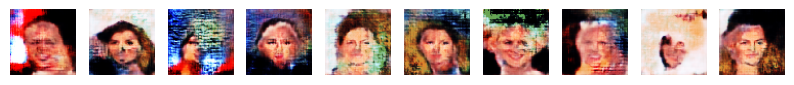

325000 -0.11539017129689455 -0.12290844321250916


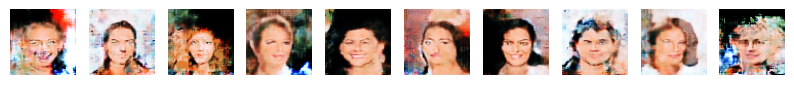

350000 -0.12602224573493004 -0.03903486207127571


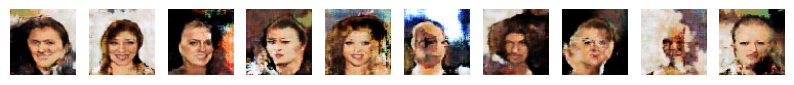

375000 0.02940510120242834 0.03829902410507202


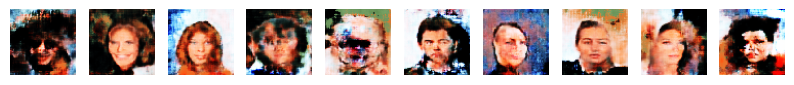

400000 -0.11637635342776775 -0.10815351456403732


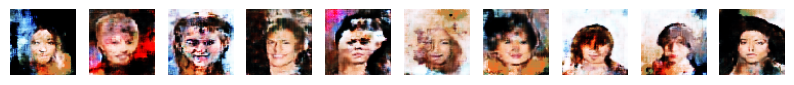

425000 -0.17342230305075645 -0.09466779232025146


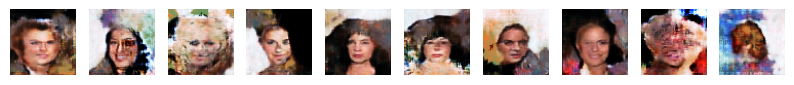

450000 -0.13893167674541473 -0.0617871917784214


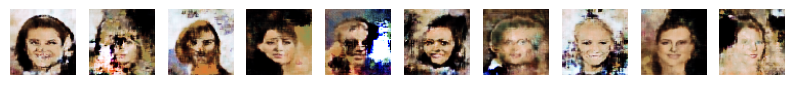

475000 -0.2314380295574665 0.13377085328102112


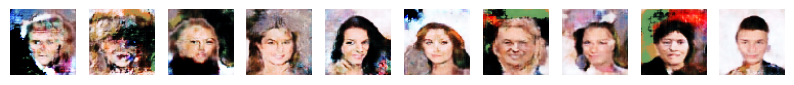

In [9]:
def train():
    for epoch in range(50_0000):
        for _ in range(5):
            loss_cls = train_cls()

        loss_gen = train_gen()

        if epoch % 25000 == 0:
            print(epoch, loss_cls, loss_gen)
            with torch.no_grad():
                pred = gen(torch.randn(10, 784, device=device))
            show(pred)


local_training = True

if local_training:
    train()

In [10]:
from transformers import PreTrainedModel, PretrainedConfig


class Model(PreTrainedModel):
    config_class = PretrainedConfig

    def __init__(self, config):
        super().__init__(config)
        self.cls = cls.to('cpu')
        self.gen = gen.to('cpu')


if local_training:
    #保存训练好的模型到hub
    Model(PretrainedConfig()).push_to_hub(
        repo_id='lansinuote/gen.4.wgan',
        use_auth_token=open('/root/hub_token.txt').read().strip())

pytorch_model.bin:   0%|          | 0.00/59.9M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

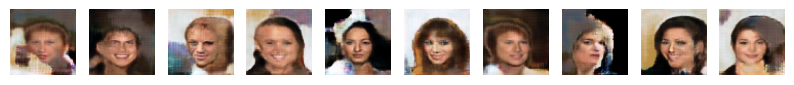

In [11]:
#加载训练好的模型
gen = Model.from_pretrained('lansinuote/gen.4.wgan').gen

with torch.no_grad():
    pred = gen(torch.randn(10, 784))

show(pred)